In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image


In [26]:
base_path = Path("/om/user/akiruga/probe3d/diffusion-forcing-transformer")
import sys 
sys.path.append(base_path)
sys.path.append(f"{base_path}/gradio_demo")

In [ ]:
from algorithms.dfot import DFoTVideoPose
from omegaconf import OmegaConf
from utils.ckpt_utils import download_pretrained  # Or pass path directly

cfg = OmegaConf.load("diffusion-forcing-transformer/gradio_demo/config.yaml")  # you may need to modify this path
model = DFoTVideoPose.load_from_checkpoint(
    checkpoint_path=download_pretrained("pretrained:DFoT_RE10K.ckpt"),
    map_location="cuda",
    cfg=cfg,
).eval().cuda()


/om/user/akiruga/sw/envs/RCDM/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.4


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets.utils import download_and_extract_archive
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import os

# MiDaS for pseudo-GT depth
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid").eval().cuda()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform

# Preprocessing for custom image
custom_img_path = Path(f"{base_path}/experiments/probe/res/realestate10k_1.webp")  # You can change this
image = Image.open(custom_img_path).convert("RGB")
depth_input = midas_transforms(np.array(image)).cuda()



# Get depth pseudo-GT
with torch.no_grad():
    depth_map = midas(depth_input)  # already batched
depth_map = F.interpolate(depth_map.unsqueeze(1), size=(256, 256), mode="bilinear", align_corners=False)
depth_map = depth_map.squeeze().cpu()

# Transform image to match DFoT input
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
img_tensor = transform(image).unsqueeze(0).cuda()  # [1, 3, H, W]
T = 40
x_repeated = img_tensor.unsqueeze(1).repeat(1, T, 1, 1, 1).cuda()  # [1, T, 3, H, W]



Using cache found in /home/akiruga/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/akiruga/.cache/torch/hub/intel-isl_MiDaS_master


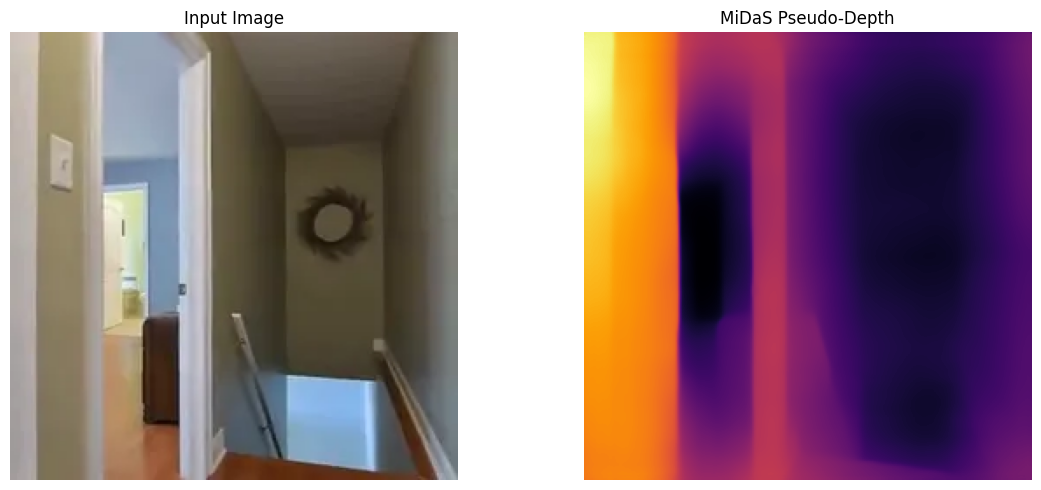

In [14]:
import matplotlib.pyplot as plt

# Visualize the input image and corresponding depth map
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Input image
axs[0].imshow(image)
axs[0].set_title("Input Image")
axs[0].axis("off")

# Depth map
axs[1].imshow(depth_map.numpy(), cmap="inferno")
axs[1].set_title("MiDaS Pseudo-Depth")
axs[1].axis("off")

plt.tight_layout()
plt.show()


In [16]:
# Download and load RealEstate10K Tiny for pose trajectory
DATASET_URL = "https://huggingface.co/kiwhansong/DFoT/resolve/main/datasets/RealEstate10K_Tiny.tar.gz"
DATASET_DIR = Path("data/real-estate-10k-tiny")
if not DATASET_DIR.exists():
    DATASET_DIR.mkdir(parents=True, exist_ok=True)
    download_and_extract_archive(DATASET_URL, DATASET_DIR.parent, remove_finished=True)

metadata = torch.load(DATASET_DIR / "metadata" / "test.pt", weights_only=False)
poses = torch.load(DATASET_DIR / "test_poses" / f"{metadata['video_paths'][0].stem}.pt")
poses = torch.cat([poses[:, :4], poses[:, 6:]], dim=-1).float()
indices = torch.linspace(0, poses.size(0) - 1, T, dtype=torch.long)
conditions = poses[indices].unsqueeze(0).to("cuda")  # [1, T, 16]

In [45]:
# Load DFoT
from omegaconf import OmegaConf
from algorithms.dfot import DFoTVideoPose
from utils.ckpt_utils import download_pretrained

cfg = OmegaConf.load(f"{base_path}/gradio_demo/config.yaml")
dfot = DFoTVideoPose.load_from_checkpoint(
    checkpoint_path=download_pretrained("pretrained:DFoT_RE10K.ckpt"),
    map_location="cuda",
    cfg=cfg,
).eval().cuda()

# # Hook to capture intermediate transformer tokens
# features = {}
# def hook_fn(name):
#     def _hook(module, input, output):
#         features[name] = output.detach()
#     return _hook

# # Register to mid_block 8
# handle = dfot.diffusion_model.model.mid_blocks[8].register_forward_hook(hook_fn("block8"))



features = {}

def register_hooks(model):
    def hook_fn(name):
        def _hook(module, input, output):
            features[name] = output.detach()
            # print(f"[HOOK] {name}: {output.shape}")
        return _hook

    model.embed_input.register_forward_hook(hook_fn("embed_input"))

    for i, block in enumerate(model.down_blocks):
        block[-1].register_forward_hook(hook_fn(f"down_{i}_downsample"))

    for i, block in enumerate(model.mid_blocks):
        block.register_forward_hook(hook_fn(f"mid_{i}"))

    for i, block in enumerate(model.up_blocks):
        block[0].register_forward_hook(hook_fn(f"up_{i}_upsample"))

    model.project_output.register_forward_hook(hook_fn("project_output"))

register_hooks(dfot.diffusion_model.model)


# Run forward pass and collect features
with torch.no_grad():
    # _ = dfot._predict_videos(dfot._normalize_x(x_repeated), conditions)
    gen_video = dfot._unnormalize_x(
        dfot._predict_videos(dfot._normalize_x(x_repeated), conditions)
    )
tokens = features["block8"]  # Expected shape: [1, T, D] or [1, T, H, W, D]

# Fit a probe: simple MLP to map tokens -> depth
hidden_dim = tokens.shape[-1]
probe = nn.Sequential(
    nn.Linear(hidden_dim, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
).cuda()

# Prepare inputs/outputs
x_probe = tokens[:, 0]  # [1, D]
y_target = depth_map.view(-1).unsqueeze(0).cuda()  # flatten to match pred

# Forward through probe
pred_depth = probe(x_probe).view(1, 1, 256, 256)  # [1, 1, H, W]

# Compute loss
loss = F.l1_loss(pred_depth, depth_map.unsqueeze(0).unsqueeze(0).cuda())
loss_value = loss.item()

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(pred_depth.squeeze().cpu().numpy(), cmap="inferno")
axs[0].set_title("Predicted Depth")
axs[1].imshow(depth_map.numpy(), cmap="inferno")
axs[1].set_title("Pseudo-GT Depth")
plt.tight_layout()
plt.show()



KeyError: 'block8'

In [46]:
for name, feat in features.items():
    print(f"{name:20s} → {feat.shape}")


embed_input          → torch.Size([16, 128, 128, 128])
down_0_downsample    → torch.Size([16, 256, 64, 64])
down_1_downsample    → torch.Size([16, 576, 32, 32])
down_2_downsample    → torch.Size([16, 1152, 16, 16])
mid_0                → torch.Size([2, 2048, 1152])
mid_1                → torch.Size([2, 2048, 1152])
mid_2                → torch.Size([2, 2048, 1152])
mid_3                → torch.Size([2, 2048, 1152])
mid_4                → torch.Size([2, 2048, 1152])
mid_5                → torch.Size([2, 2048, 1152])
mid_6                → torch.Size([2, 2048, 1152])
mid_7                → torch.Size([2, 2048, 1152])
mid_8                → torch.Size([2, 2048, 1152])
mid_9                → torch.Size([2, 2048, 1152])
mid_10               → torch.Size([2, 2048, 1152])
mid_11               → torch.Size([2, 2048, 1152])
mid_12               → torch.Size([2, 2048, 1152])
mid_13               → torch.Size([2, 2048, 1152])
mid_14               → torch.Size([2, 2048, 1152])
mid_15              

In [47]:
print("conditions.shape:", conditions.shape)
print("x_repeated.shape:", x_repeated.shape)


conditions.shape: torch.Size([1, 40, 16])
x_repeated.shape: torch.Size([1, 40, 3, 256, 256])


In [22]:
gen_video.shape

torch.Size([1, 40, 3, 256, 256])

In [27]:
from export import export_to_video, export_to_gif, export_images_to_gif
fps = 4
export_to_video(gen_video[0].detach().cpu(), fps=fps)

'/tmp/tmp8os8z0cu.mp4'

In [32]:
from torchvision.transforms.functional import to_pil_image
b= to_pil_image(x_repeated[0, 0].cpu())


In [34]:
print("Video stats before export:")
print("min:", gen_video[0].min().item())
print("max:", gen_video[0].max().item())


Video stats before export:
min: -3.271638870239258
max: 3.148055076599121


# using features

In [39]:
print("Token shape:", tokens.shape)


Token shape: torch.Size([2, 2048, 1152])
